In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix,classification_report
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import plotly.io as pio
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
df4_train = pd.read_csv("Dataset-MobilePrice/df4_train.csv")
df4_test = pd.read_csv("Dataset-MobilePrice/df4_test.csv")

In [3]:
df4_train.head()

battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
0            842     0          2.2         0   1       0           7   
1           1021     1          0.5         1   0       1          53   
2            563     1          0.5         1   2       1          41   
3            615     1          2.5         0   0       0          10   
4           1821     1          1.2         0  13       1          44   

   mobile_wt  n_cores  pc   ram  talk_time  three_g  touch_screen  wifi  \
0        188        2   2  2549         19        0             0     1   
1        136        3   6  2631          7        1             1     0   
2        145        5   6  2603          9        1             1     0   
3        131        6   9  2769         11        1             0     0   
4        141        2  14  1411         15        1             1     0   

   price_range  
0            1  
1            2  
2            2  
3            2  
4            1

<span style="font-size:20px; color: magenta; font-weight:bold;">EDA</span>

<span style="font-size:14px; color: black;font-weight:bold">To be easier to follow, first I provided essential graphs for the train data set and then for the test dataset</span>

<span style="font-size:16px; color: black; font-weight:bold;">Train dataset</span>

In [28]:
true_num_cols = [
    'battery_power',
    'clock_speed',
    'fc',
    'int_memory',
    'mobile_wt',
    'pc',
    'ram',
    'talk_time'
]

In [29]:
true_cat_cols = [col for col in df4_train.columns if col not in true_num_cols]

In [30]:
for col in true_cat_cols:
    df4_train[col] = df4_train[col].astype('category')

In [31]:
cat_cols_train = df4_train.select_dtypes(include='category').columns
num_cols_train = df4_train.select_dtypes(include=['int64', 'float64']).columns

In [32]:
cat_cols_train

Index(['blue', 'dual_sim', 'four_g', 'n_cores', 'three_g', 'touch_screen',
       'wifi', 'price_range'],
      dtype='object')

In [33]:
num_cols_train

Index(['battery_power', 'clock_speed', 'fc', 'int_memory', 'mobile_wt', 'pc',
       'ram', 'talk_time'],
      dtype='object')

In [35]:
num_cols = [
    'battery_power', 'clock_speed', 'fc', 'int_memory',
    'mobile_wt', 'pc', 'ram', 'talk_time'
]

for col in num_cols:
    df4_train[col] = pd.to_numeric(df4_train[col], errors='coerce')

In [36]:
df4_train.dtypes

battery_power       int64
blue             category
clock_speed       float64
dual_sim         category
fc                  int64
four_g           category
int_memory          int64
mobile_wt           int64
n_cores          category
pc                  int64
ram                 int64
talk_time           int64
three_g          category
touch_screen     category
wifi             category
price_range      category
dtype: object

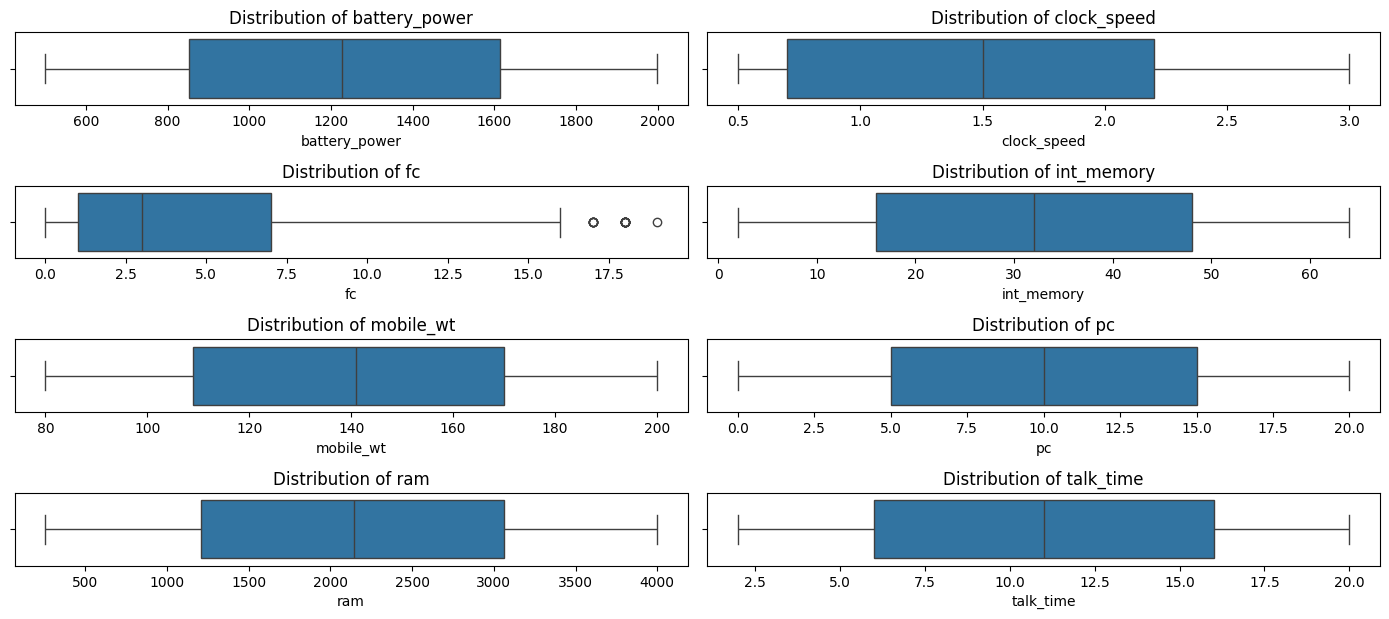

In [37]:
fig,axes=plt.subplots(8,2, figsize=(14,12))
axes=axes.flatten()
for i,col in enumerate(num_cols_train):
    sns.boxplot(data=df4_train, x=col, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
for j in range(len(num_cols_train), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Figures-Mobile Price/Train/BoxPlot Distribution.png", 
            dpi=300, bbox_inches='tight')
plt.show()

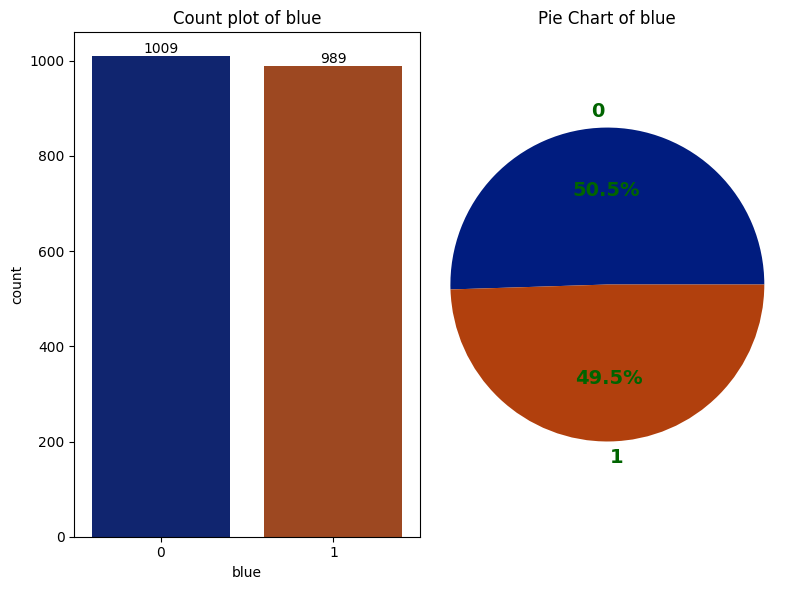

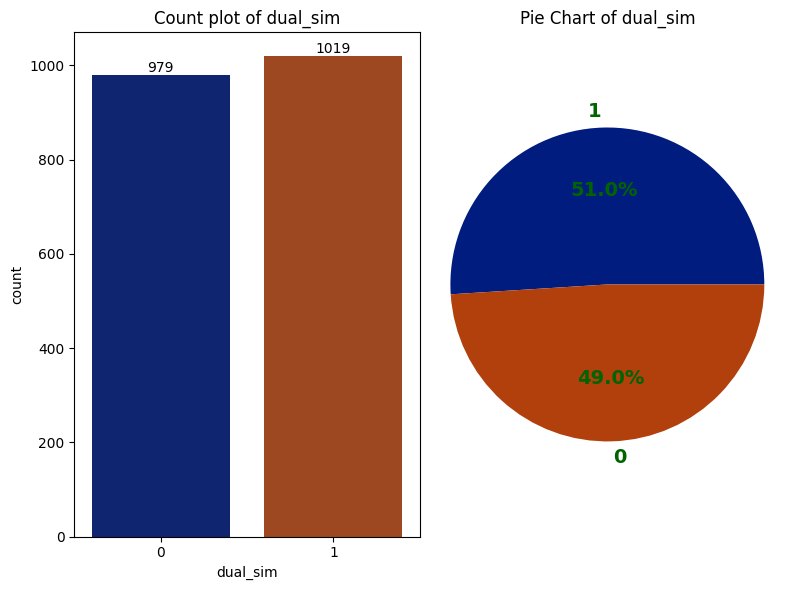

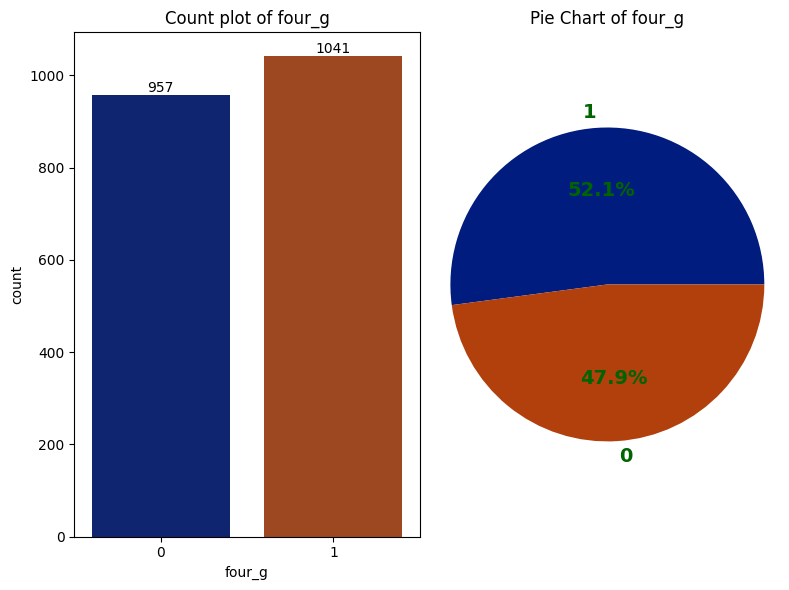

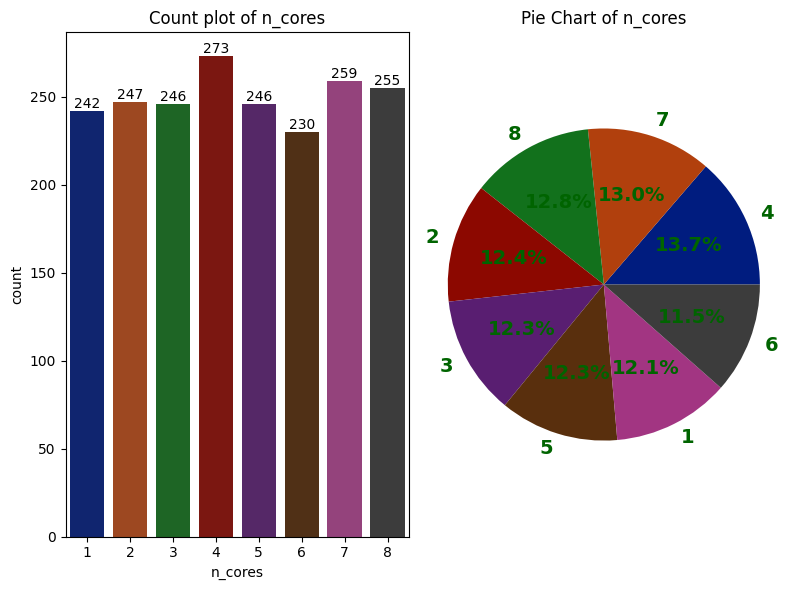

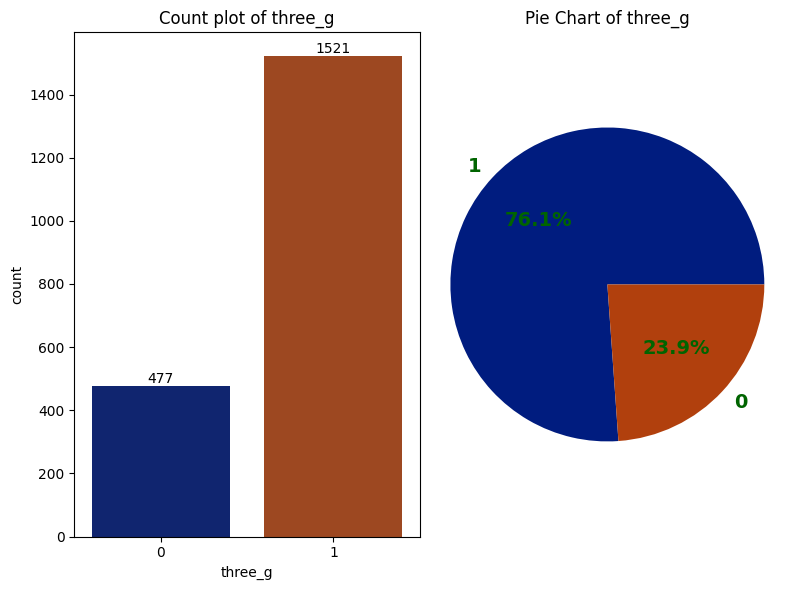

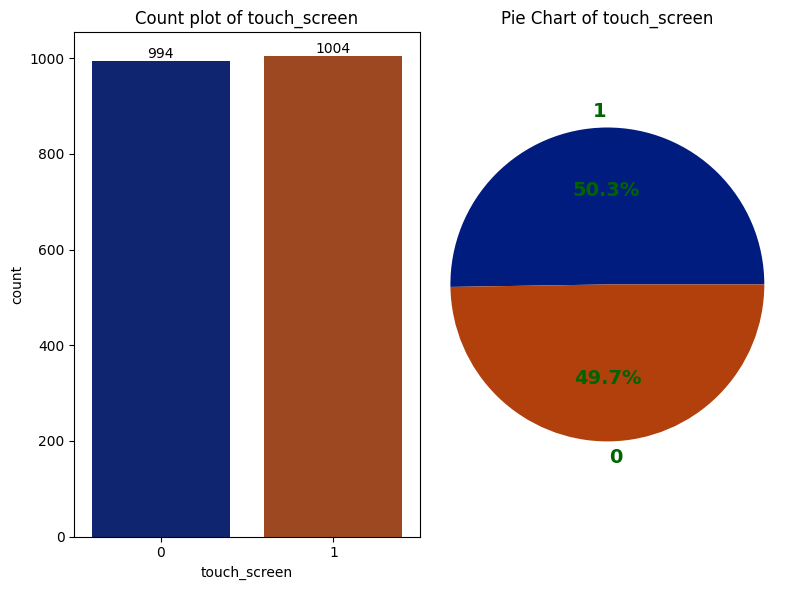

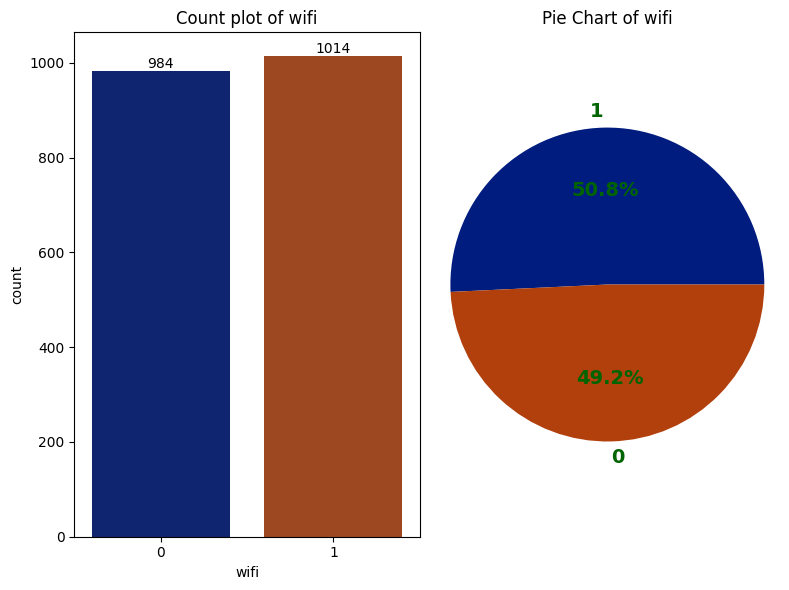

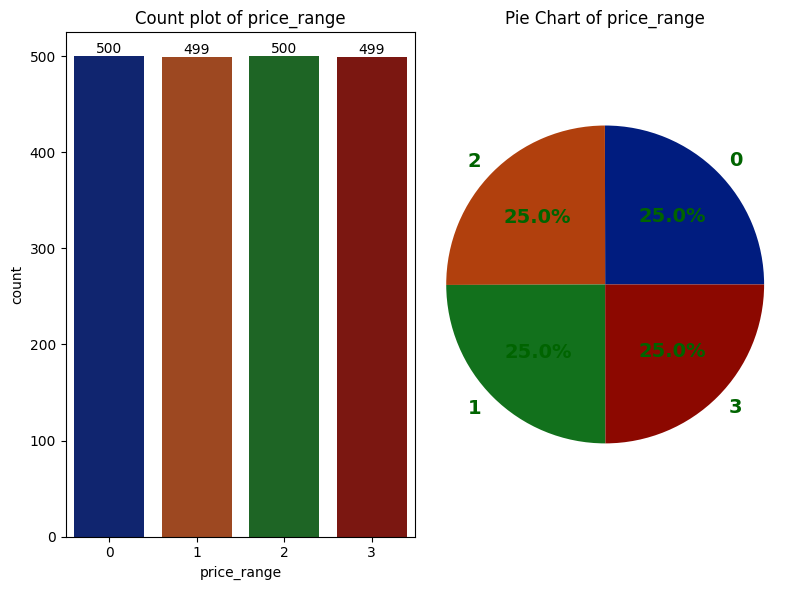

In [50]:
for col in cat_cols_train:
    fig,axes=plt.subplots(1,2,figsize=(8,6))
    sns.countplot(data=df4_train,x=col,hue=col,ax=axes[0],palette='dark',legend=False)
    axes[0].set_title(f"Count plot of {col}")
    axes[0].tick_params(axis='x')
    for p in axes[0].patches:
        count=int(p.get_height())
        axes[0].annotate(f'{count}',(p.get_x()+p.get_width()/2.,p.get_height()),ha='center',va='bottom')

    #pie chart
    value_counts=df4_train[col].value_counts()
    colors=sns.color_palette('dark')
    axes[1].pie(value_counts,labels=value_counts.index,autopct='%1.1f%%', startangle=0,colors=colors,textprops={'color':'darkgreen','fontsize':14,'fontweight':'bold'})
    axes[1].set_title(f"Pie Chart of {col}")
    axes[1].axis('equal')
    plt.tight_layout()
    plt.savefig(f"Figures-Mobile Price/Train/Count_Plot_{col}.png",
                dpi=300, bbox_inches='tight')

    plt.show()

Several categorical features in the dataset exhibit approximately uniform distributions. For instance, the presence or absence of Bluetooth is nearly evenly split, suggesting no dominant class. Similarly, the price range variable is evenly distributed across its four defined categories, indicating a deliberate or unbiased binning strategy.

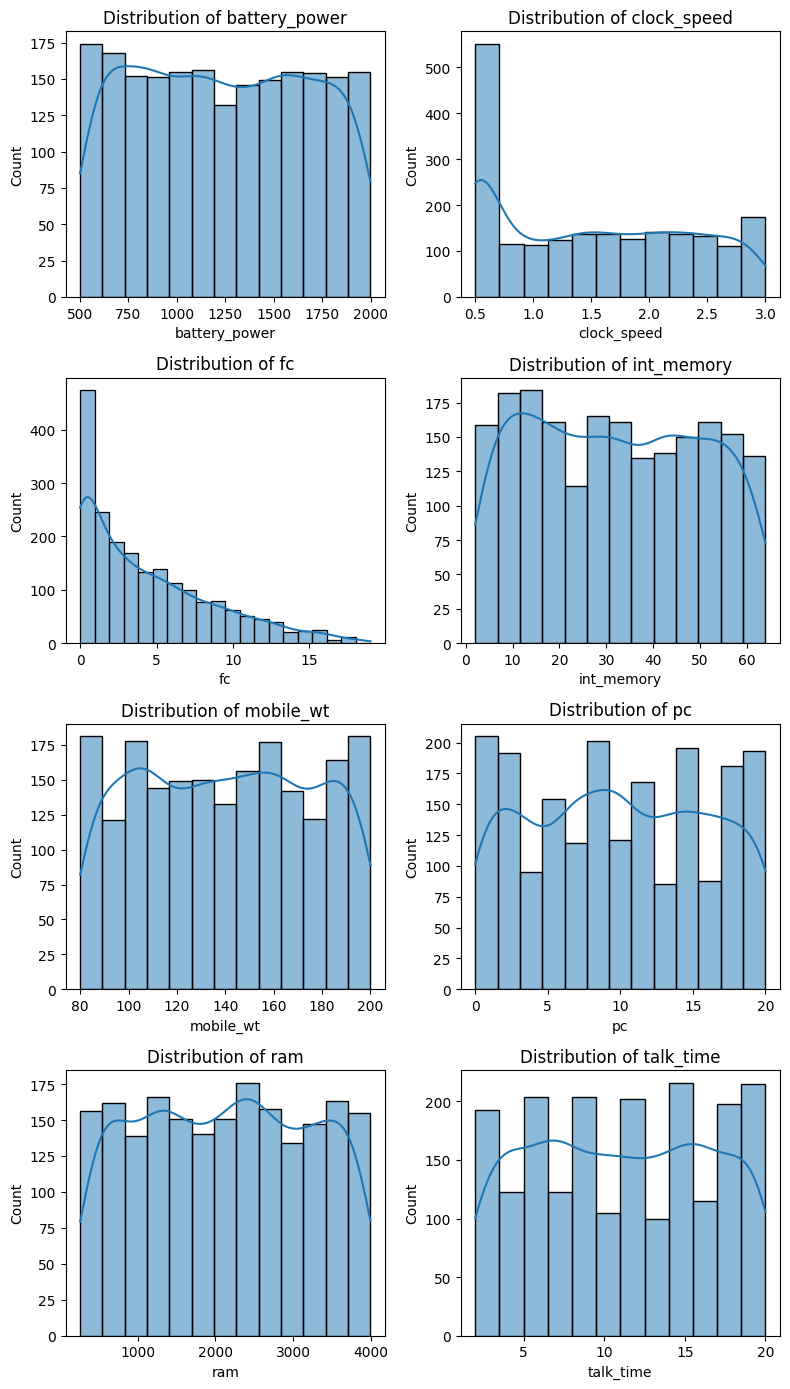

In [40]:
fig,axes=plt.subplots(4,2,figsize=(8,14))
axes=axes.flatten()
for i,col in enumerate(num_cols_train):
    sns.histplot(data=df4_train, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.savefig("Figures-Mobile Price/Train/num_cols Distribution.png", 
            dpi=300, bbox_inches='tight')
plt.show()


Most numerical features in the dataset exhibit approximately normal distributions, indicating a well-behaved data structure suitable for parametric modeling. However, fc and clock_speed show noticeable right skewness, with a concentration of values toward the lower end and a long tail extending to higher values. 


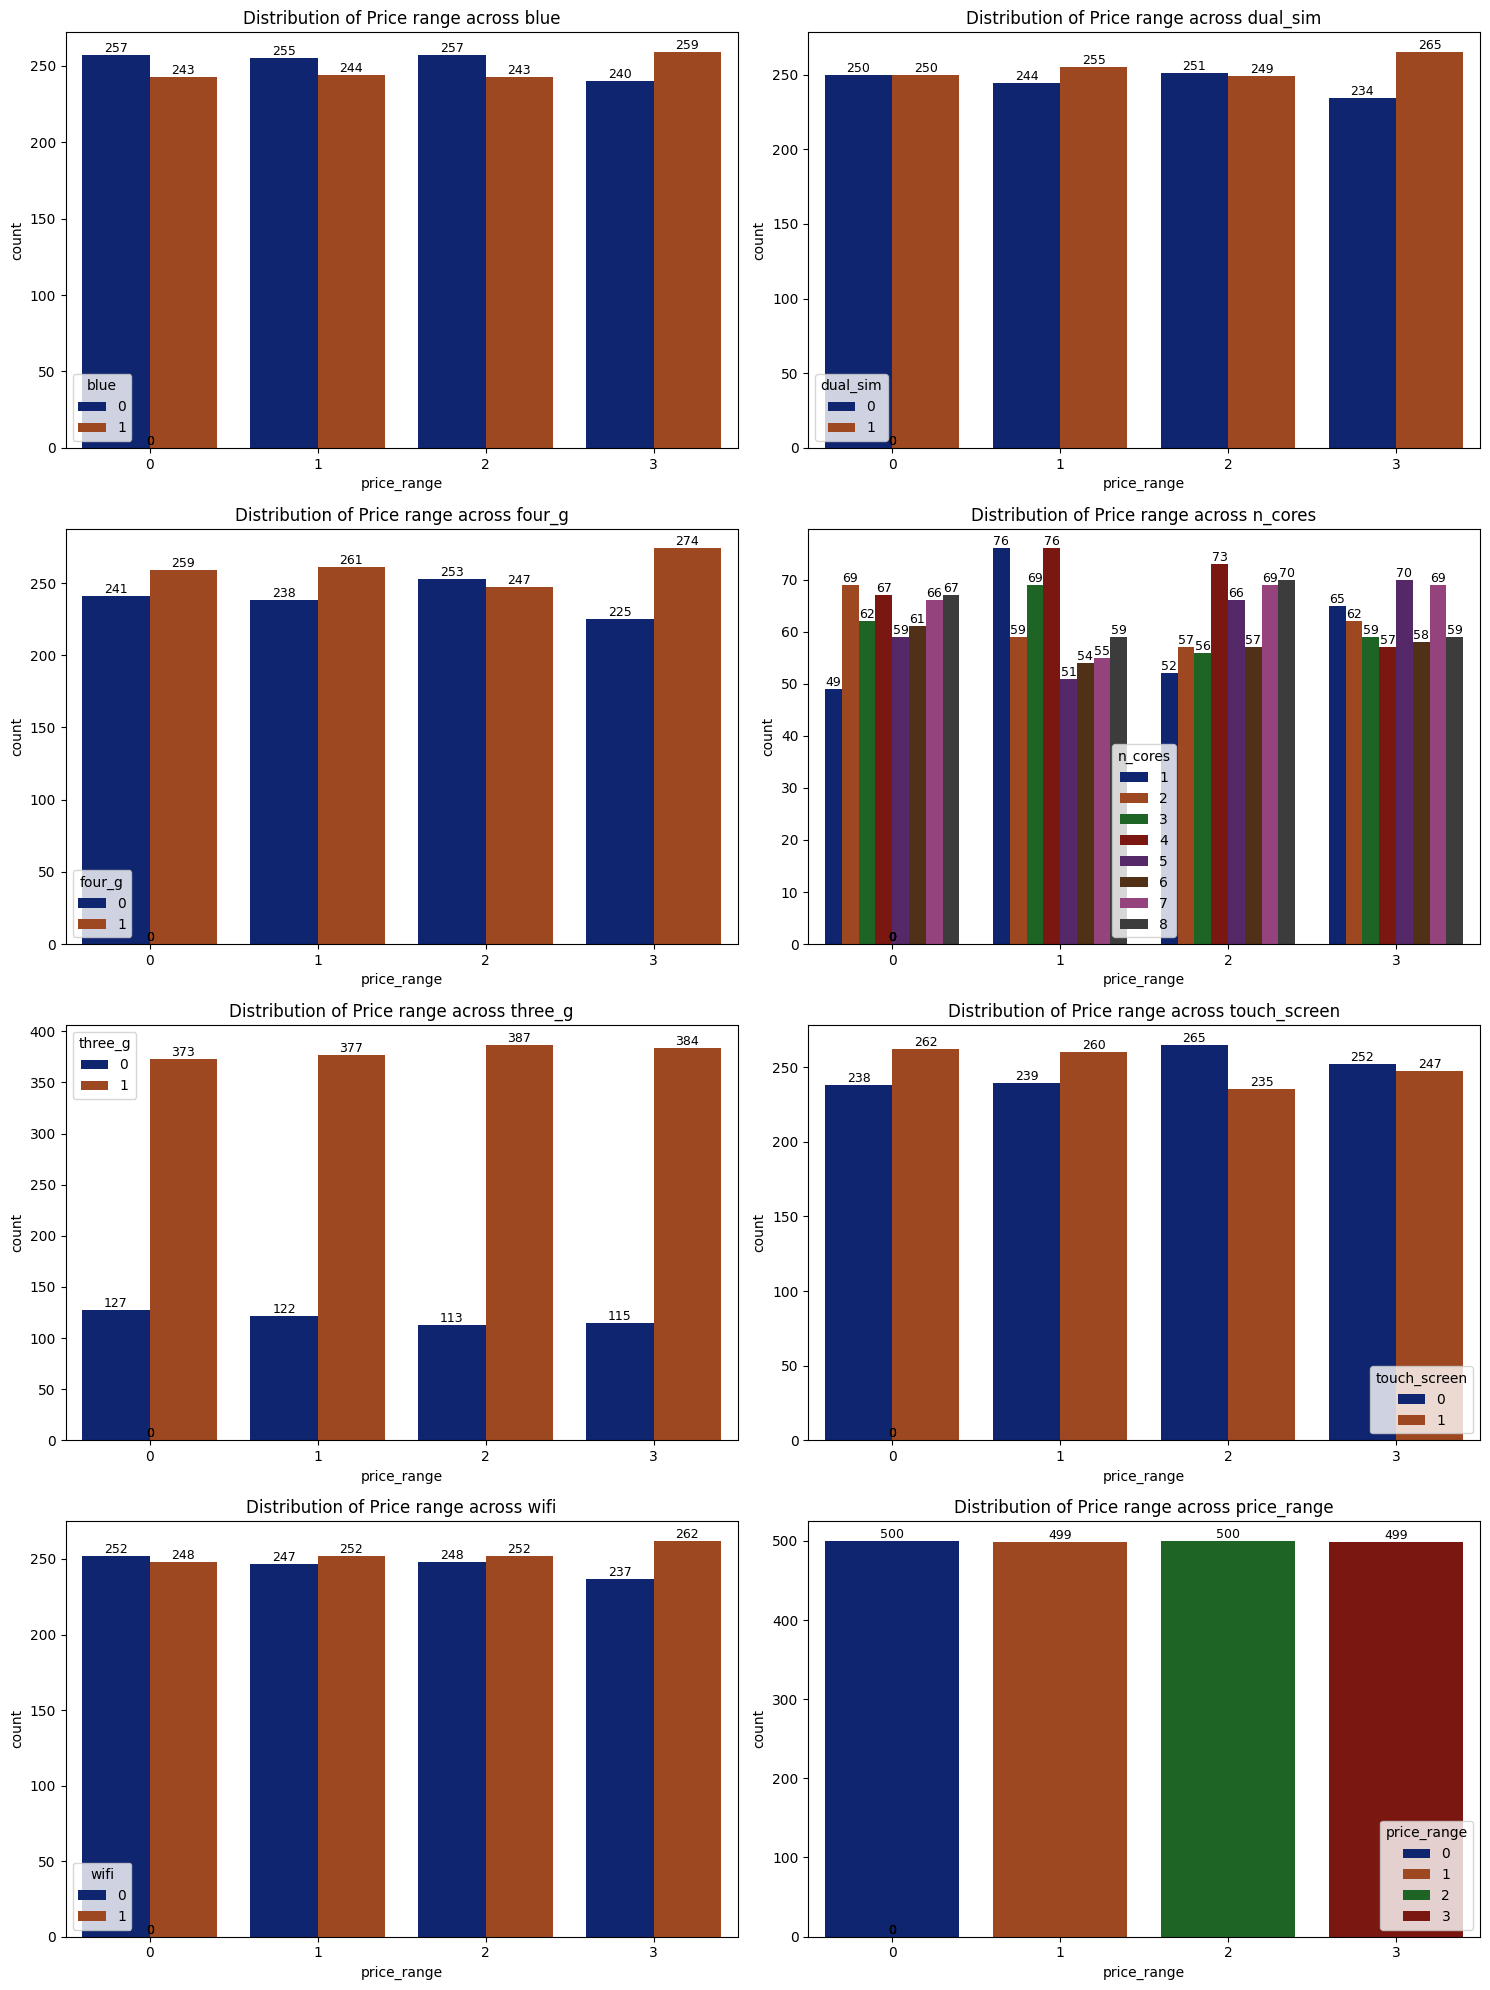

In [41]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))  
axes = axes.flatten()  
for i, col in enumerate(cat_cols_train):
    sns.countplot(data=df4_train, x='price_range', hue=col, ax=axes[i],
                  palette='dark', legend=True)
    axes[i].set_title(f"Distribution of Price range across {col}")
    axes[i].tick_params(axis='x')
    for p in axes[i].patches:
        count = int(p.get_height())
        axes[i].annotate(f'{count}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom', fontsize=9)

for j in range(len(cat_cols_train), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig("Figures-Mobile Price/Train/cat_cols Distribution2.png", 
            dpi=300, bbox_inches='tight')
plt.show()

Across the categorical features blue, dual_sim, four_g, three_g, touch_screen, and wifi, we observed a consistent pattern.
The distribution of price_range is nearly uniform across all categories of these features.
This means that whether a phone has Bluetooth, dual SIM, 4G, 3G, a touchscreen, or WiFi, the number of phones in each price category (0 to 3) remains roughly the same. These features are common across all price levels and do not show strong separation between low-end and high-end devices.
For example:
- Phones with and without Bluetooth are evenly spread across all price ranges.
- The same applies to dual SIM, 4G, 3G, touchscreen, and WiFi , no feature shows a clear trend toward higher or lower price categories.
  * Unlike the binary features, n_cores (number of processor cores) shows a less uniform distribution across price ranges. Some core counts are more frequent in certain price categories:
    - Lower core counts (e.g., 1–3 cores) appear more often in lower price ranges.
    - Higher core counts (e.g., 6–8 cores) are more frequent in higher price ranges.
This suggests that n_cores may have a positive association with price — phones with more cores tend to fall into higher price categories.





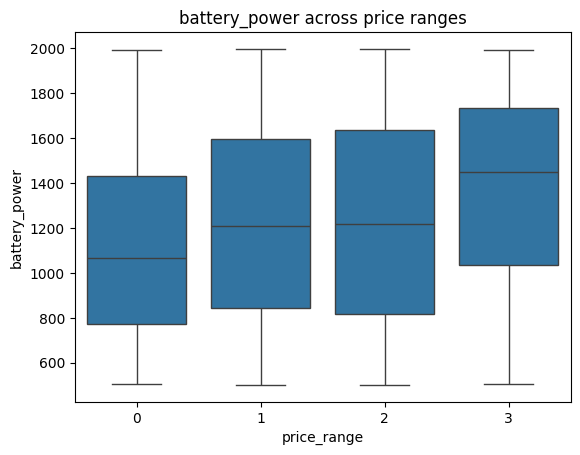

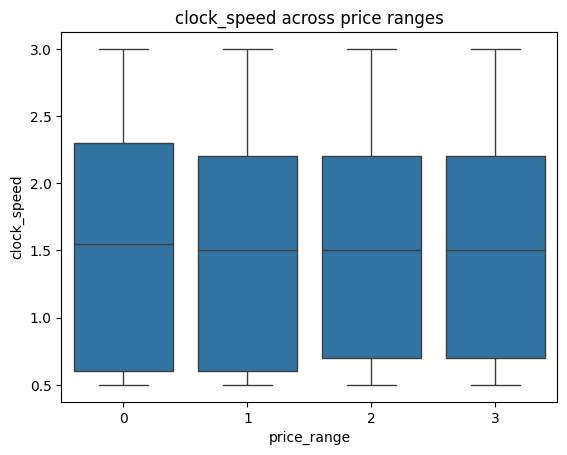

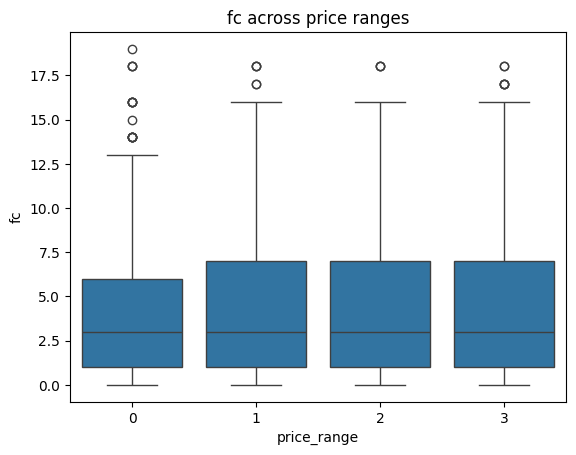

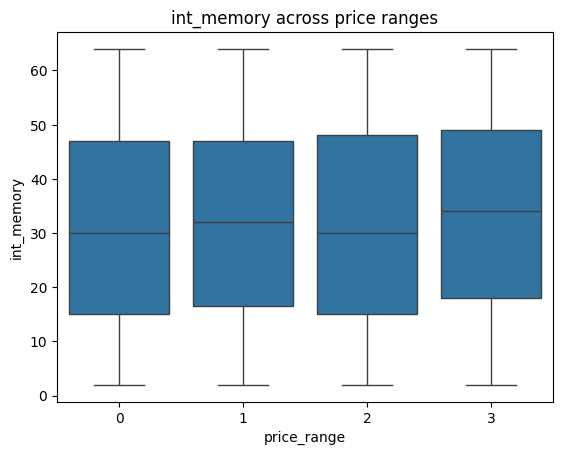

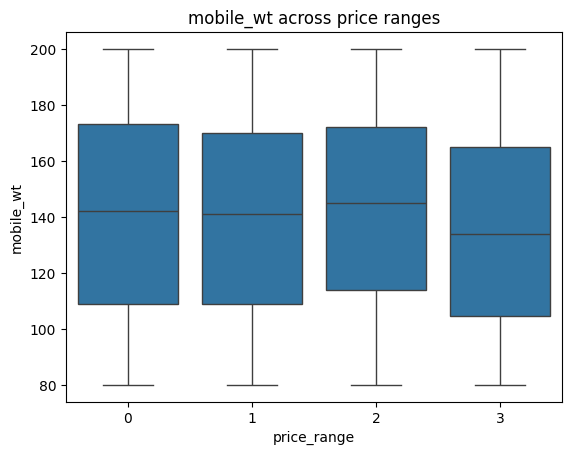

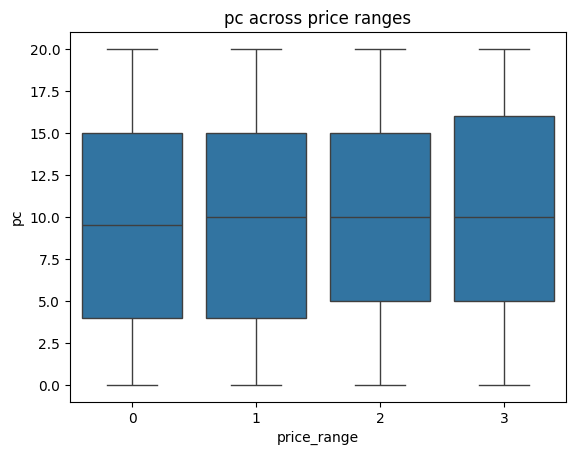

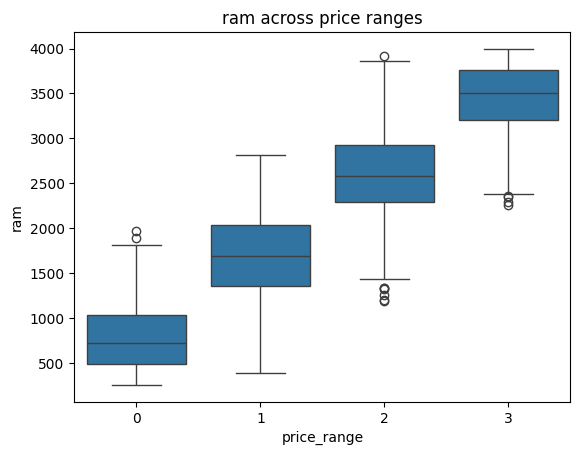

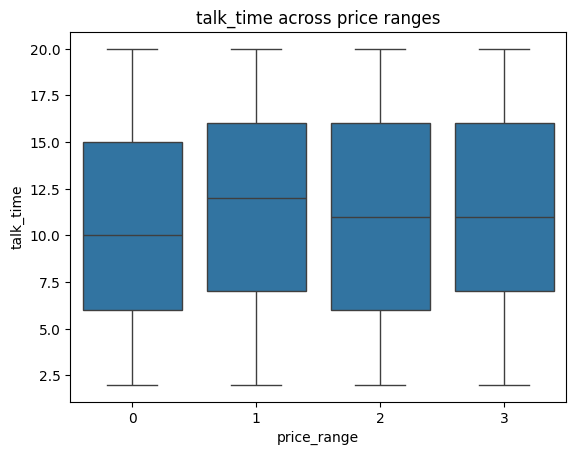

In [49]:
for col in num_cols_train:
    sns.boxplot(data=df4_train, x='price_range', y=col)
    plt.title(f"{col} across price ranges")
    plt.savefig(f"Figures-Mobile Price/Train/Box_Plot_{col}.png",
                dpi=300, bbox_inches='tight')

    plt.show()

+ Ram has a significant influence on the price range, and higher RAM causes a higher price.

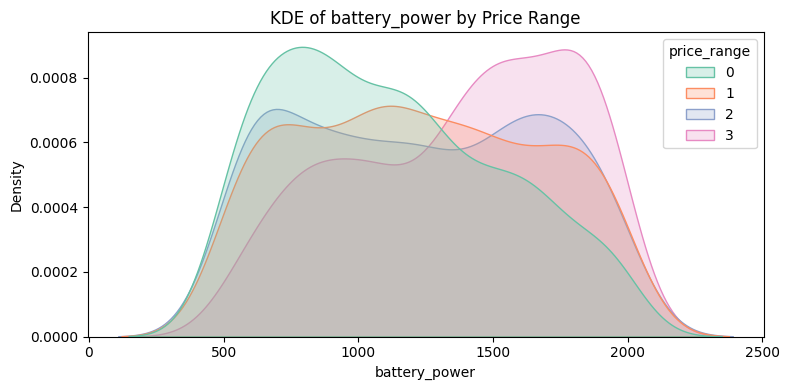

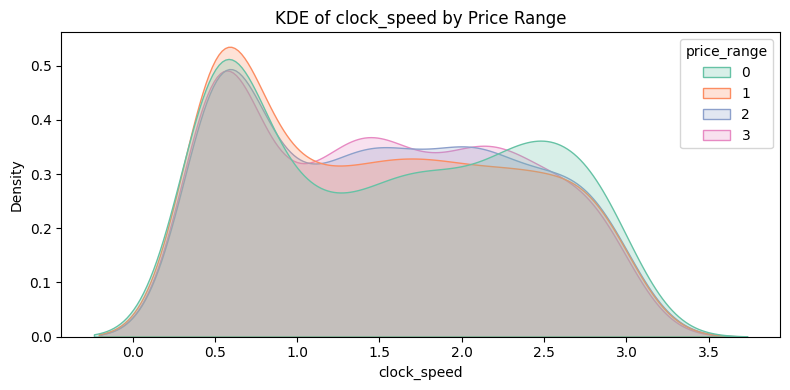

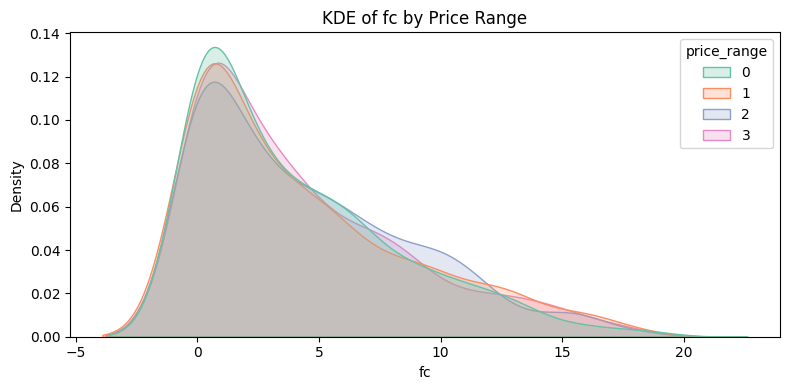

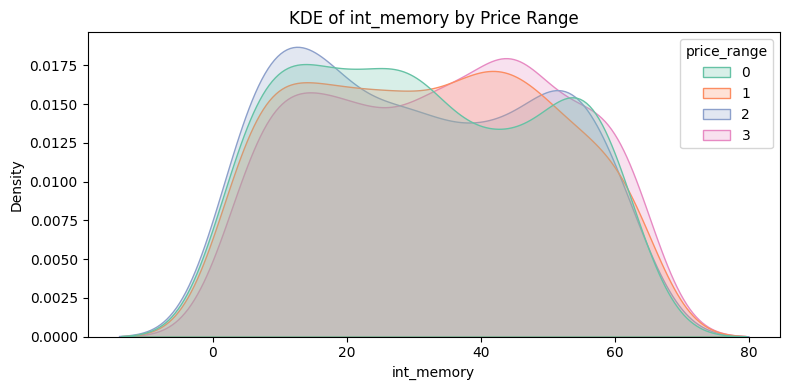

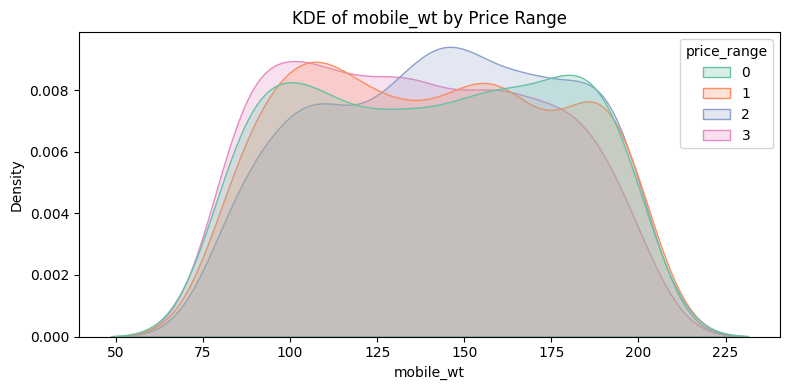

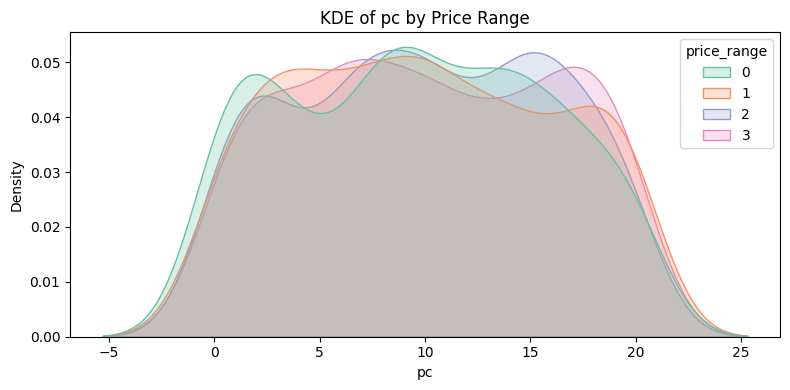

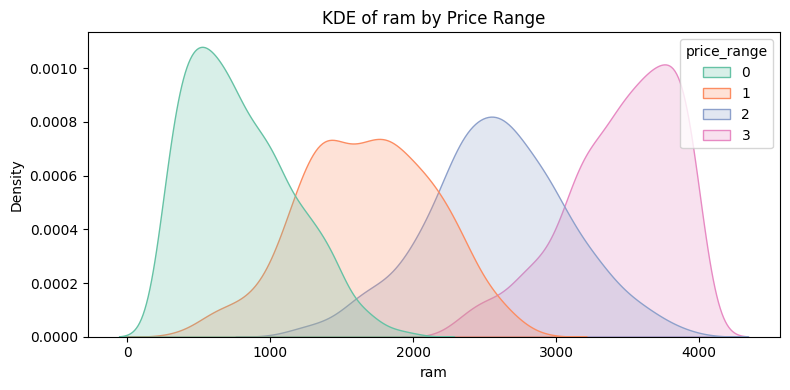

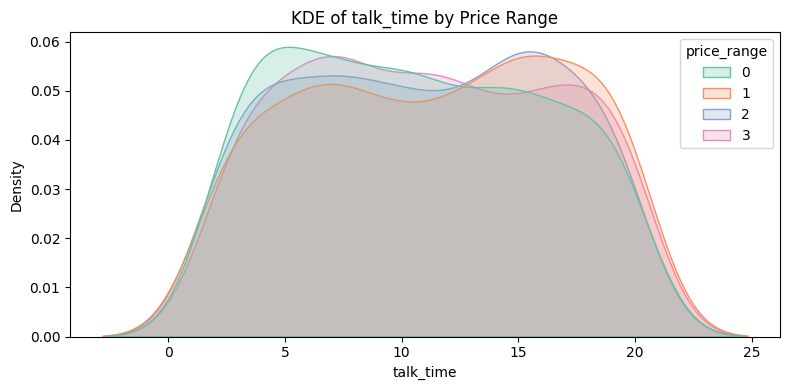

In [48]:
for col in num_cols_train:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df4_train, x=col, hue='price_range',
                fill=True, common_norm=False, palette='Set2')
    plt.title(f"KDE of {col} by Price Range")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.savefig(f"Figures-Mobile Price/Train/KDE_{col}.png",
                dpi=300, bbox_inches='tight')

    plt.show()


    * Lower_priced mobiles have lower battery power and in lower prices, the battery power is around 700, although in the higher price, the battery power is around 1600W.
    * in all prices, the peak of clock speed is around 0.5h
    * in all prices range, most mobiles have fc from 0 to 1
    * int-memory for range price 1,3 has higher density
    * we can say the weight of the mobile and pc do not change the price significantly
    * RAM has great affect on mobile price
    

<span style="font-size:14px; color: black;font-weight:bold">Since RAM shows the strongest influence on mobile price, we’ll use it as the reference axis and plot other numerical features against it. By coloring the points by price_range, we can explore how combinations of RAM and other features relate to pricing.
</span>


<span style="font-size:12xp;color:naivy;font-weight:bold;">Numerical features: </span>

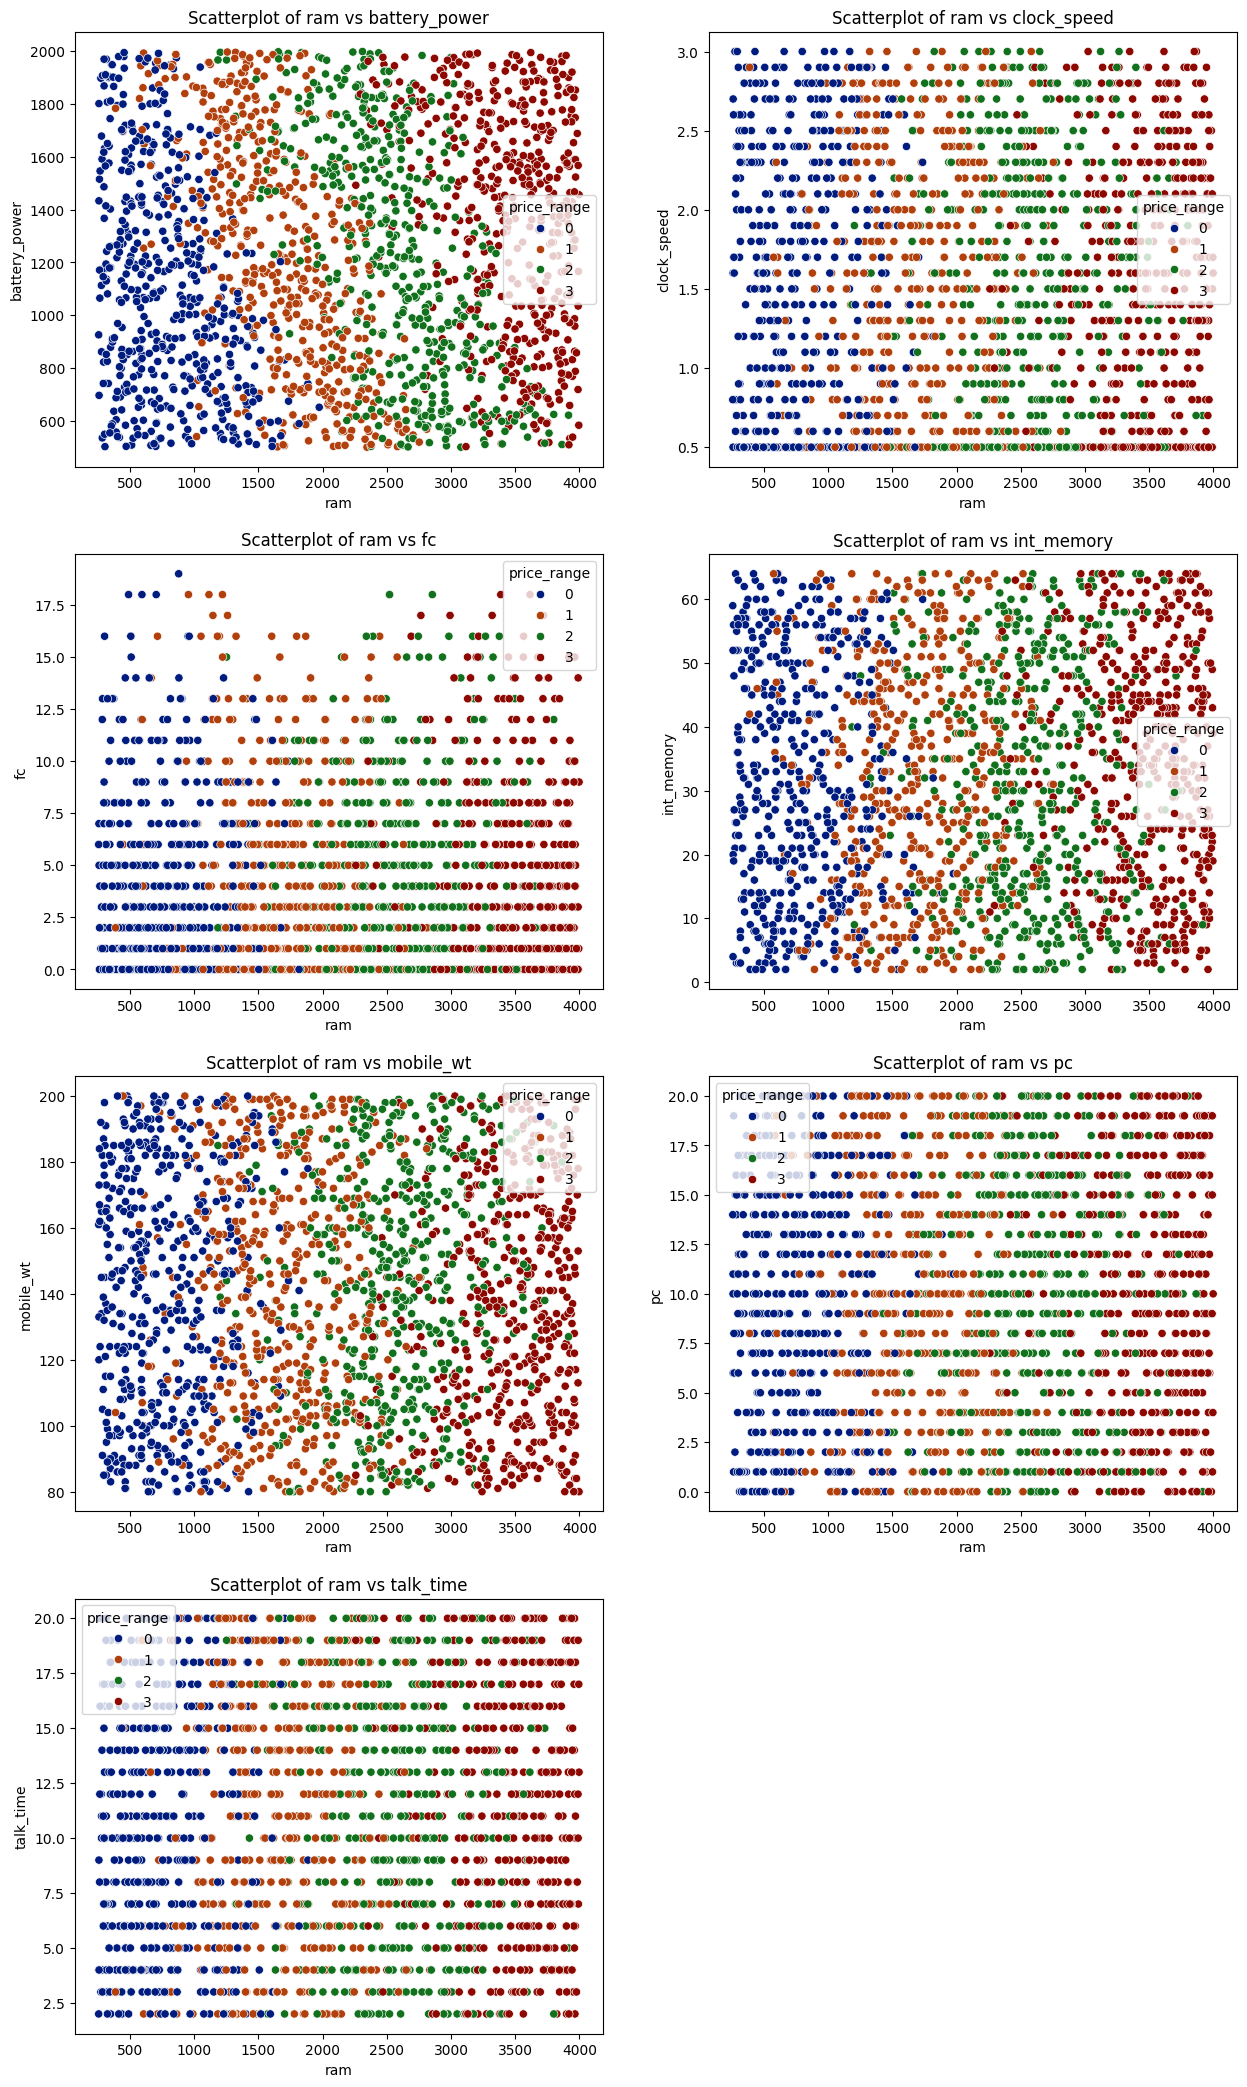

In [44]:
fig, ax = plt.subplots(4,2,figsize=(15,26))
num_cols_train_2 =list( num_cols_train)
num_cols_train_2.remove('ram')
for i, col in enumerate(num_cols_train_2):
    sns.scatterplot(data=df4_train, x='ram', y=col, hue='price_range', ax=ax[i//2, i%2], palette='dark')
    ax[i//2, i%2].set_title(f'Scatterplot of ram vs {col}')
for j in range(len(num_cols_train_2), len(ax.flatten())):
    ax.flatten()[j].set_visible(False)
plt.savefig("Figures-Mobile Price/Train/Scatter Plot_Num Cols.png", 
            dpi=300, bbox_inches='tight')
plt.show()

<span style="font-size:12xp;color:naivy;font-weight:bold;">Categorical features: </span>

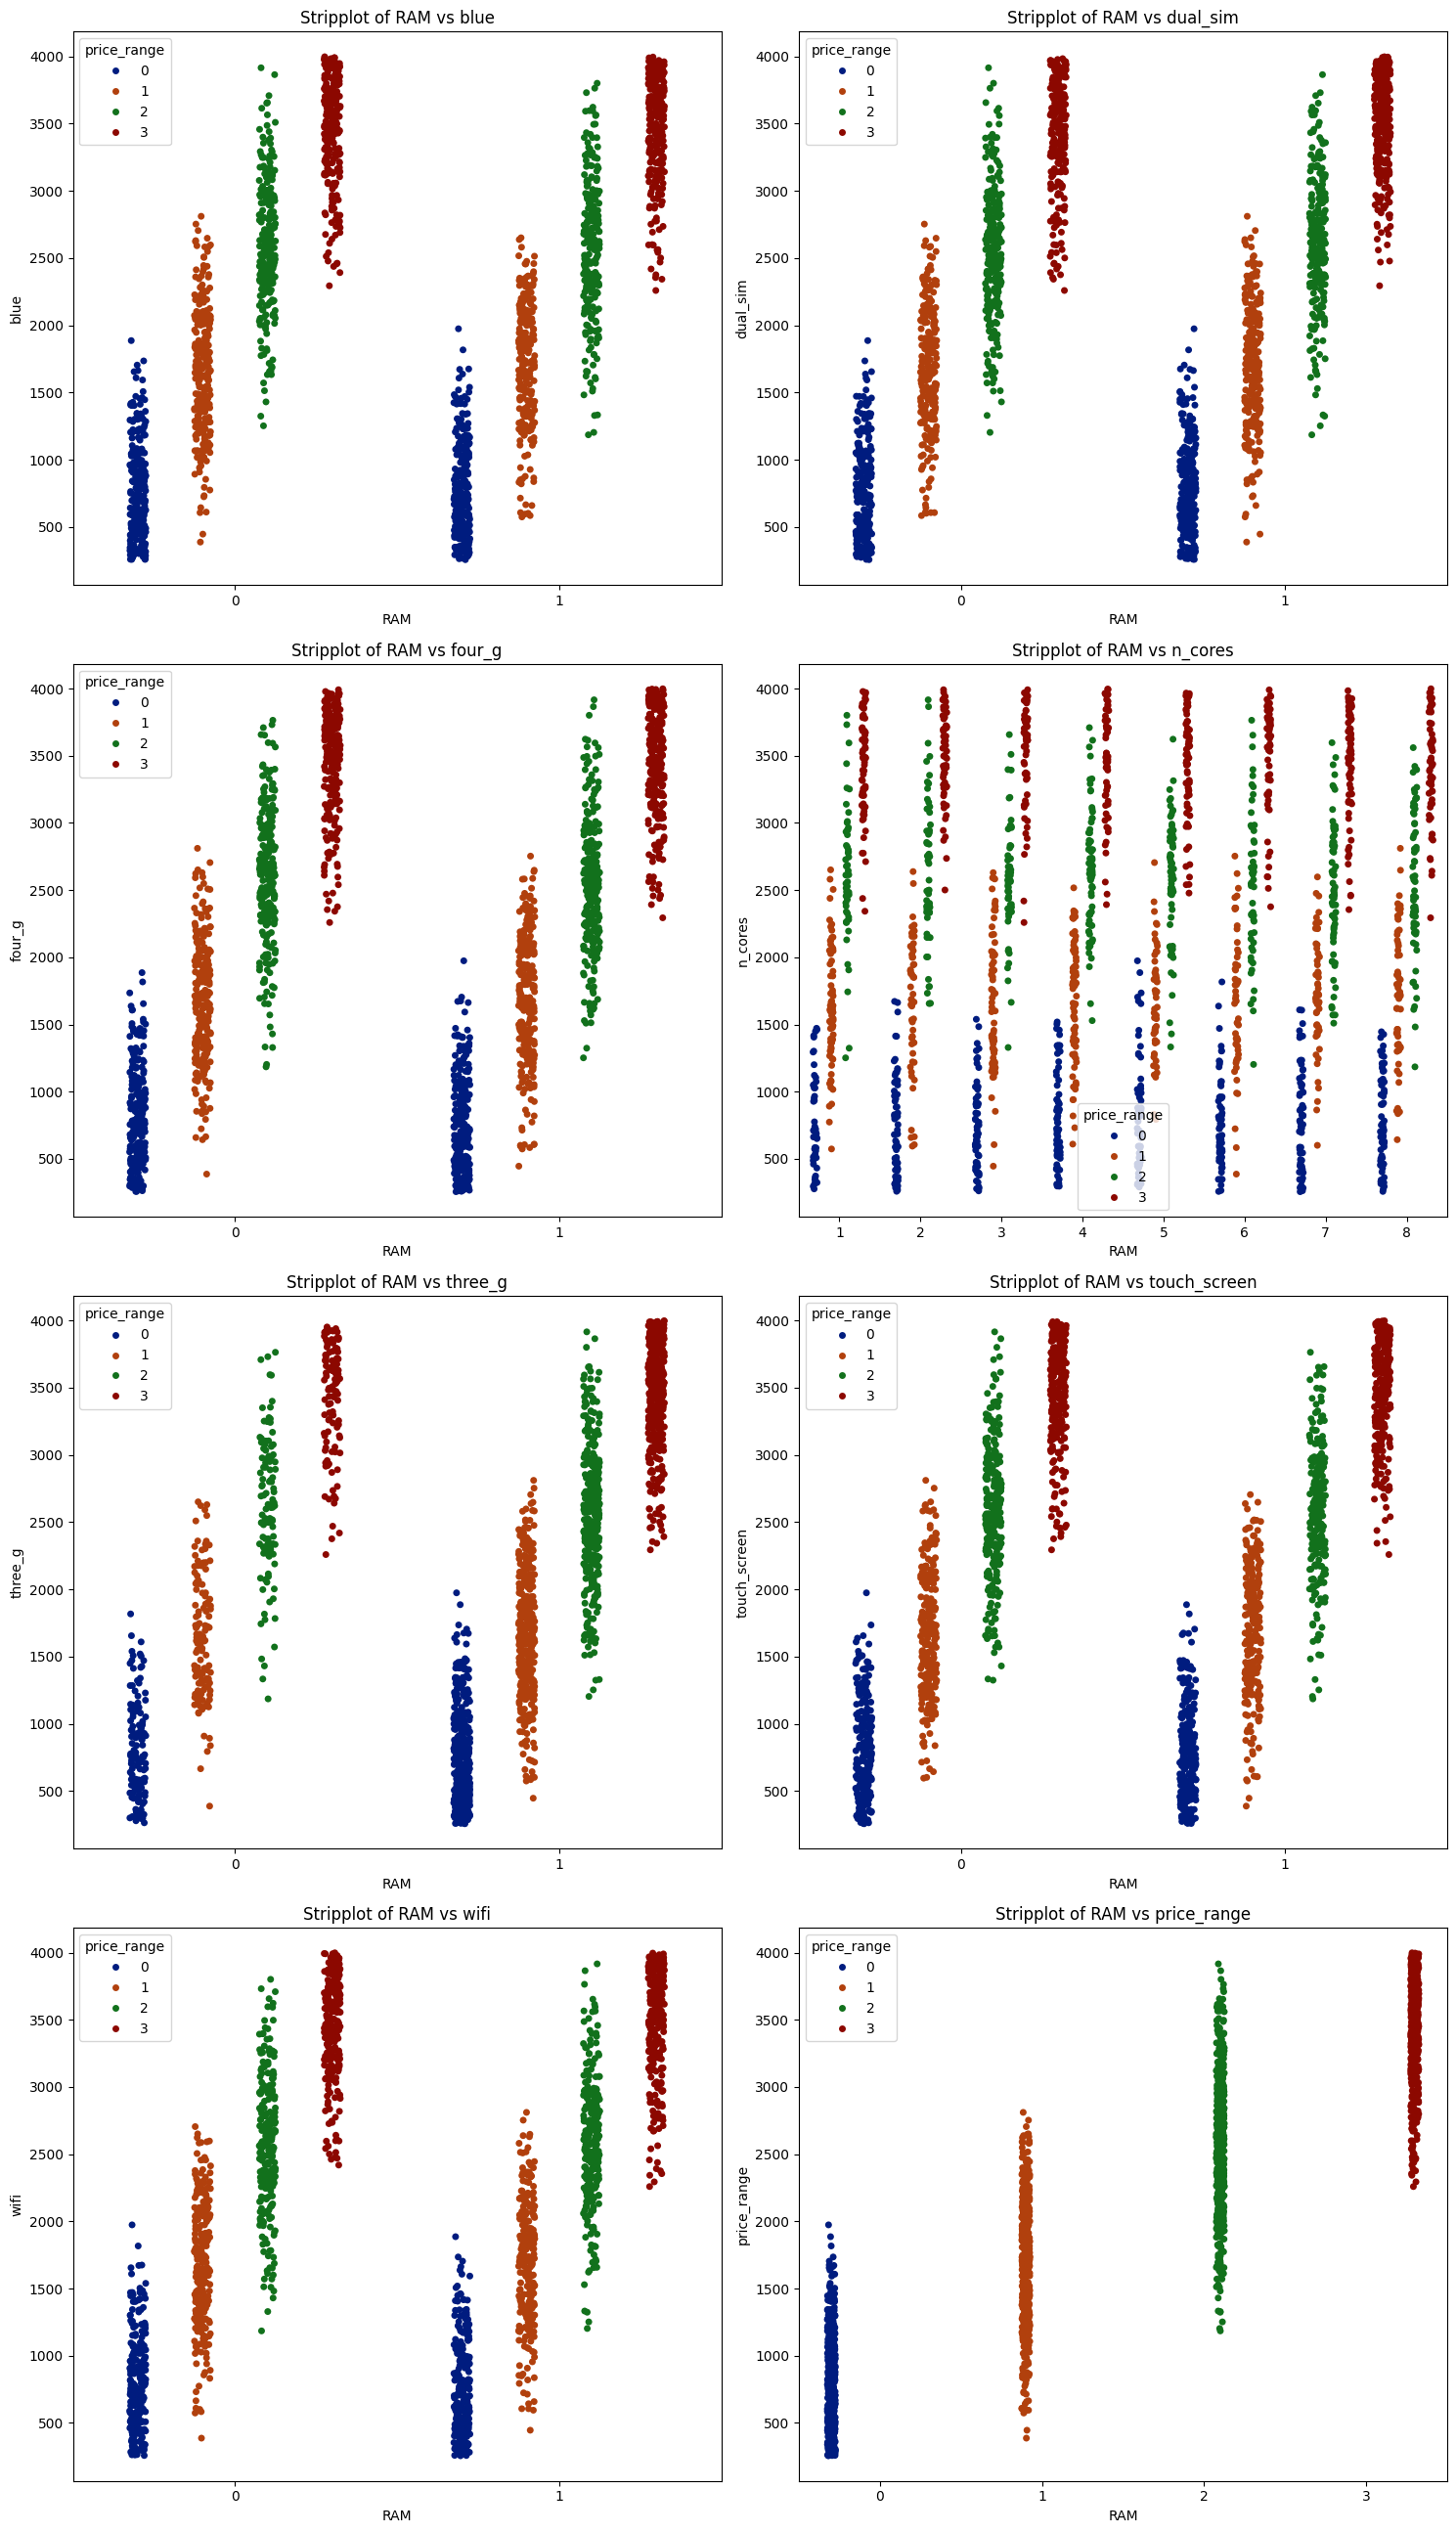

In [45]:
fig, ax = plt.subplots(4, 2, figsize=(15, 26))
for i, col in enumerate(cat_cols_train):
    sns.stripplot(data=df4_train, x=col, y='ram', hue='price_range',
                  ax=ax[i//2, i%2], palette='dark', dodge=True, jitter=True)
    ax[i//2, i%2].set_title(f'Stripplot of RAM vs {col}')
    ax[i//2, i%2].set_xlabel('RAM')
    ax[i//2, i%2].set_ylabel(col)

for j in range(len(cat_cols_train), len(ax.flatten())):
    ax.flatten()[j].set_visible(False)

plt.tight_layout()
plt.savefig("Figures-Mobile Price/Train/Stripplot Plot_Cum Cols.png", 
            dpi=300, bbox_inches='tight')
plt.show()

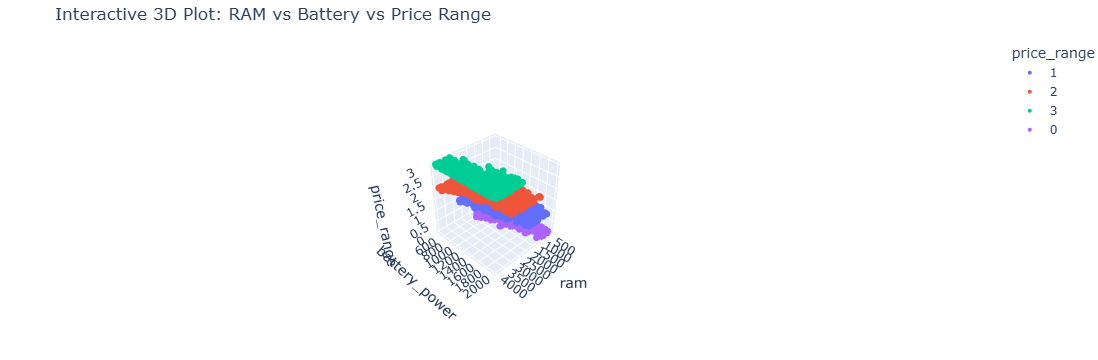

In [46]:
fig = px.scatter_3d(df4_train,
                    x='ram',
                    y='battery_power',
                    z='price_range',
                    color='price_range',
                    hover_data=['fc','clock_speed','int_memory'],
                    title='Interactive 3D Plot: RAM vs Battery vs Price Range')

fig.update_traces(marker=dict(size=4))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()

The scatterplots confirm our earlier observations: several features appear to be equally distributed across RAM levels, with limited separation between price categories. This suggests that, aside from RAM, many features may have weaker individual influence on pricing.